<a href="https://colab.research.google.com/github/LuisRoberto96/Exercicios_Hadoop/blob/main/Exercicios%20Aula%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Instalando o Apache Spark
O que é: Um framework para processamento de Big Data


In [148]:
# Instalando o PySpark
!apt-get -qq update
!apt-get -qq install -y openjdk-17-jdk-headless
!pip -q install -U pyspark[connect]==4.0.0

print('✅ PySpark instalado com sucesso!')
#Depois de concluir a instalação, reiniciar o runtime

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ PySpark instalado com sucesso!


# 2. Criando uma SparkSession

In [149]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Criando uma SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('AnaliseECommerce') \
    .getOrCreate()

print('✅ SparkSession criada com sucesso!')

✅ SparkSession criada com sucesso!


Dados <-- Streamin ou consulta -- PySpark --> SparkServer

# 3. Carregando dados do Google Drive

In [150]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Caminho dos datasets
DATA_PATH = '/content/drive/MyDrive/curso_hadoop/'

# Carregar os datasets
df_clientes = spark.read.csv(DATA_PATH + 'clientes.csv', header=True, inferSchema=True)
df_produtos = spark.read.csv(DATA_PATH + 'produtos.csv', header=True, inferSchema=True)
df_vendas = spark.read.csv(DATA_PATH + 'vendas.csv', header=True, inferSchema=True)

print('✅ Datasets carregados com sucesso!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Datasets carregados com sucesso!


# 4. Explorando os DataFrames

In [151]:
# Visualizar schema do Dataframe (Schema = estrutura)
print('Schema do DataFrame de Vendas:')
df_vendas.printSchema()

Schema do DataFrame de Vendas:
root
 |-- id_venda: integer (nullable = true)
 |-- data_venda: date (nullable = true)
 |-- id_produto: integer (nullable = true)
 |-- produto: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- quantidade: integer (nullable = true)
 |-- preco_unitario: double (nullable = true)
 |-- valor_total: double (nullable = true)
 |-- id_cliente: integer (nullable = true)
 |-- cliente: string (nullable = true)
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)



In [152]:
# Visualizar as primeiras 5 linhas do dataframe de vendas
df_vendas.show(5)

+--------+----------+----------+----------------+-----------+----------+--------------+-----------+----------+-------------+--------+------+
|id_venda|data_venda|id_produto|         produto|  categoria|quantidade|preco_unitario|valor_total|id_cliente|      cliente|  regiao|estado|
+--------+----------+----------+----------------+-----------+----------+--------------+-----------+----------+-------------+--------+------+
|       1|2024-01-01|       101|   Notebook Dell|Eletrônicos|         2|        3500.0|     7000.0|      1001|   João Silva| Sudeste|    SP|
|       2|2024-01-02|       102|  Mouse Logitech|Periféricos|         5|         150.0|      750.0|      1002| Maria Santos| Sudeste|    RJ|
|       3|2024-01-03|       103|Teclado Mecânico|Periféricos|         3|         450.0|     1350.0|      1003|  Pedro Costa|     Sul|    RS|
|       4|2024-01-04|       104|   Monitor LG 27|Eletrônicos|         1|        1200.0|     1200.0|      1004| Ana Oliveira|Nordeste|    BA|
|       5|202

In [153]:
# Contando registros de um dataframe
print(f'Total de vendas:{df_vendas.count()}')
print(f'Total de clientes:{df_clientes.count()}')
print(f'Total de produtos:{df_produtos.count()}')

Total de vendas:30
Total de clientes:500
Total de produtos:200


# 5. Operações com DataFrame

In [154]:
# Selecionar dados de venda, cliente e preço
df_venda_simples = df_vendas.select('id_venda', 'id_cliente', 'valor_total')
df_venda_simples.show(5)

+--------+----------+-----------+
|id_venda|id_cliente|valor_total|
+--------+----------+-----------+
|       1|      1001|     7000.0|
|       2|      1002|      750.0|
|       3|      1003|     1350.0|
|       4|      1004|     1200.0|
|       5|      1005|     1120.0|
+--------+----------+-----------+
only showing top 5 rows


In [155]:
# Filtrar linhas por valor, exemplo, vendas maiores que 2000
vendas_altas = df_vendas.filter(col('valor_total') > 2000)
print(f'Total de vendas maior que 2000,00: {vendas_altas.count()}')
vendas_altas.show(5)

Total de vendas maior que 2000,00: 9
+--------+----------+----------+-------------+-----------+----------+--------------+-----------+----------+----------------+-------+------+
|id_venda|data_venda|id_produto|      produto|  categoria|quantidade|preco_unitario|valor_total|id_cliente|         cliente| regiao|estado|
+--------+----------+----------+-------------+-----------+----------+--------------+-----------+----------+----------------+-------+------+
|       1|2024-01-01|       101|Notebook Dell|Eletrônicos|         2|        3500.0|     7000.0|      1001|      João Silva|Sudeste|    SP|
|       6|2024-01-06|       101|Notebook Dell|Eletrônicos|         1|        3500.0|     3500.0|      1006|   Fernanda Lima|  Norte|    PA|
|       9|2024-01-09|       104|Monitor LG 27|Eletrônicos|         2|        1200.0|     2400.0|      1009|Marcelo Ferreira|    Sul|    PR|
|      11|2024-01-11|       101|Notebook Dell|Eletrônicos|         1|        3500.0|     3500.0|      1011|  Thiago Martins

In [157]:
# Agrupar vendas por cliente (somando o valor das vendas)
vendas_por_cliente = df_vendas.groupBy('id_cliente').agg(
    count('id_venda').alias('total_vendas'),
    sum('valor_total').alias('total_gasto')
)
vendas_por_cliente.show(5)

+----------+------------+-----------+
|id_cliente|total_vendas|total_gasto|
+----------+------------+-----------+
|      1025|           1|      560.0|
|      1005|           1|     1120.0|
|      1016|           1|    10500.0|
|      1030|           1|      280.0|
|      1019|           1|     2400.0|
+----------+------------+-----------+
only showing top 5 rows


In [159]:
# Join entre dataframes (vendas e clientes)

df_vendas_clientes = df_vendas.join(
    df_clientes, df_vendas.id_cliente == df_clientes.cliente_id, 'inner')
print('Vendas com informações de clientes:')
df_vendas_clientes.select(df_clientes.cliente_id, df_clientes.nome, df_vendas.valor_total).show(5)

Vendas com informações de clientes:
+----------+------------------+-----------+
|cliente_id|              nome|valor_total|
+----------+------------------+-----------+
|      1004|        Ísis Lopes|     1200.0|
|      1020|Maria Clara da Luz|     1400.0|
|      1019| Ana Laura Fonseca|     2400.0|
|      1014|  Vicente da Cunha|     1200.0|
|      1029|     Beatriz Ramos|     3600.0|
+----------+------------------+-----------+
only showing top 5 rows


# 6. Spart SQL

In [161]:
# Para usar o spark sql primeiro registre o dataframe como tabela temporária no spark
df_vendas.createOrReplaceTempView('vendas')
df_clientes.createOrReplaceTempView('clientes')
df_produtos.createOrReplaceTempView('produtos')
# Execute sua consulta SQL a partir do spark.sql
resultado = spark.sql('''
  SELECT
    c.nome,
    COUNT(v.id_venda) as num_vendas,
    SUM(v.valor_total) as total_gasto
  FROM vendas v
  JOIN clientes c ON v.id_cliente = c.cliente_id
  GROUP BY c.nome
  ORDER BY total_gasto DESC
  LIMIT 10
''')
print('Top 10 de clientes por valor gasto')
resultado.show()

Top 10 de clientes por valor gasto
+--------------------+----------+-----------+
|                nome|num_vendas|total_gasto|
+--------------------+----------+-----------+
|       Beatriz Ramos|         1|     3600.0|
|   Ana Laura Fonseca|         1|     2400.0|
|      Luigi Carvalho|         1|     1800.0|
|  Maria Clara da Luz|         1|     1400.0|
|       Joaquim Silva|         1|     1350.0|
|    Levi Albuquerque|         1|     1200.0|
|          Ísis Lopes|         1|     1200.0|
|    Vicente da Cunha|         1|     1200.0|
|Maria Sophia das ...|         1|      900.0|
|      Vinícius Abreu|         1|      900.0|
+--------------------+----------+-----------+



**Exercícios**:
1. Análise de vendas por categoria e produto via Spark SQL e via Dataframe
2. Análise dos clientes que mais compraram via Spark SQL e via Dataframe
3. Aplicar os mesmos conceitos em um dataset de sua



# 1.  Análise de vendas por categoria e produto via Spark SQL e via Dataframe **negrito**




In [162]:
#Inicialização do Spark

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, desc

spark = SparkSession.builder \
    .appName("AnaliseVendas") \
    .getOrCreate()


In [163]:
#Carregar datasets

vendas = spark.read.csv(DATA_PATH + "vendas.csv", header=True, inferSchema=True)
produtos = spark.read.csv(DATA_PATH + "produtos.csv", header=True, inferSchema=True)
clientes = spark.read.csv(DATA_PATH + "clientes.csv", header=True, inferSchema=True)

In [164]:
#Criar Views para SQL

vendas.createOrReplaceTempView("vendas")
produtos.createOrReplaceTempView("produtos")
clientes.createOrReplaceTempView("clientes")


In [165]:
#1A) VIA SPARK SQL — Vendas por Categoria e Produto

query = """
SELECT
    p.categoria,
    p.nome_produto,
    SUM(v.valor_total) AS faturamento_total,
    SUM(v.quantidade) AS total_vendido
FROM vendas v
JOIN produtos p
    ON v.id_produto = p.produto_id
GROUP BY p.categoria, p.nome_produto
ORDER BY faturamento_total DESC
"""

resultado_sql = spark.sql(query)
resultado_sql.show()


+--------------+--------------------+-----------------+-------------+
|     categoria|        nome_produto|faturamento_total|total_vendido|
+--------------+--------------------+-----------------+-------------+
|   Eletrônicos|  Eletrônicos Item-1|          35000.0|           10|
|   Eletrônicos|  Eletrônicos Item-4|          12000.0|           10|
|    Brinquedos|   Brinquedos Item-3|           6750.0|           15|
|Casa e Cozinha|Casa e Cozinha It...|           6000.0|           40|
|   Eletrônicos|  Eletrônicos Item-5|           4760.0|           17|
+--------------+--------------------+-----------------+-------------+



In [166]:
#VIA DATAFRAME API

resultado_df = vendas.join(produtos, vendas.id_produto == produtos.produto_id) \
    .groupBy(produtos.categoria, produtos.nome_produto) \
    .agg(
        sum("valor_total").alias("faturamento_total"),
        sum("quantidade").alias("total_vendido")
    ) \
    .orderBy(desc("faturamento_total"))

resultado_df.show()

+--------------+--------------------+-----------------+-------------+
|     categoria|        nome_produto|faturamento_total|total_vendido|
+--------------+--------------------+-----------------+-------------+
|   Eletrônicos|  Eletrônicos Item-1|          35000.0|           10|
|   Eletrônicos|  Eletrônicos Item-4|          12000.0|           10|
|    Brinquedos|   Brinquedos Item-3|           6750.0|           15|
|Casa e Cozinha|Casa e Cozinha It...|           6000.0|           40|
|   Eletrônicos|  Eletrônicos Item-5|           4760.0|           17|
+--------------+--------------------+-----------------+-------------+





#1.    Análise dos clientes que mais compraram via Spark SQL e via Dataframe



In [167]:
#VIA SPARK SQL

query_clientes = """
SELECT
    c.nome,
    SUM(v.valor_total) AS total_gasto,
    COUNT(v.id_venda) AS total_compras
FROM vendas v
JOIN clientes c
    ON v.id_cliente = c.cliente_id
GROUP BY c.nome
ORDER BY total_gasto DESC
"""

top_clientes_sql = spark.sql(query_clientes)
top_clientes_sql.show()


+--------------------+-----------+-------------+
|                nome|total_gasto|total_compras|
+--------------------+-----------+-------------+
|       Beatriz Ramos|     3600.0|            1|
|   Ana Laura Fonseca|     2400.0|            1|
|      Luigi Carvalho|     1800.0|            1|
|  Maria Clara da Luz|     1400.0|            1|
|       Joaquim Silva|     1350.0|            1|
|    Levi Albuquerque|     1200.0|            1|
|          Ísis Lopes|     1200.0|            1|
|    Vicente da Cunha|     1200.0|            1|
|Maria Sophia das ...|      900.0|            1|
|      Vinícius Abreu|      900.0|            1|
|      Laura Monteiro|      900.0|            1|
|Dr. Francisco Nog...|      750.0|            1|
|Marcos Vinicius C...|      600.0|            1|
|    Ana Lívia Novaes|      560.0|            1|
+--------------------+-----------+-------------+



In [168]:
#VIA DATAFRAME API

top_clientes_df = vendas.join(clientes, vendas.id_cliente == clientes.cliente_id) \
    .groupBy(clientes.nome) \
    .agg(
        sum(vendas.valor_total).alias("total_gasto"),
        sum(vendas.quantidade).alias("total_itens_comprados")
    ) \
    .orderBy(desc("total_gasto"))

top_clientes_df.show()

+--------------------+-----------+---------------------+
|                nome|total_gasto|total_itens_comprados|
+--------------------+-----------+---------------------+
|       Beatriz Ramos|     3600.0|                    3|
|   Ana Laura Fonseca|     2400.0|                    2|
|      Luigi Carvalho|     1800.0|                    4|
|  Maria Clara da Luz|     1400.0|                    5|
|       Joaquim Silva|     1350.0|                    3|
|    Levi Albuquerque|     1200.0|                    1|
|          Ísis Lopes|     1200.0|                    1|
|    Vicente da Cunha|     1200.0|                    1|
|Maria Sophia das ...|      900.0|                    2|
|      Vinícius Abreu|      900.0|                    6|
|      Laura Monteiro|      900.0|                    2|
|Dr. Francisco Nog...|      750.0|                    5|
|Marcos Vinicius C...|      600.0|                    4|
|    Ana Lívia Novaes|      560.0|                    2|
+--------------------+---------

# **3. APLICAR OS MESMOS CONCEITOS EM OUTRO DATASET**

In [169]:
import requests
import pandas as pd

# API SIDRA - PIB dos estados (último ano disponível)
url = "https://apisidra.ibge.gov.br/values/t/5938/n1/all/v/37/p/last"

response = requests.get(url)
data = response.json()

# Converter para DataFrame
df = pd.DataFrame(data)

# Primeira linha é cabeçalho descritivo
df = df.iloc[1:]

# Manter colunas relevantes
df = df[["D1N", "V"]]

df.columns = ["Estado", "PIB"]

df["PIB"] = pd.to_numeric(df["PIB"])

df.head()



,Estado,PIB
1,Brasil,10943345439


In [170]:
#Inicializar Spark

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, desc

spark = SparkSession.builder \
    .appName("AnalisePIB_IBGE") \
    .getOrCreate()


In [171]:
#Converter Pandas → Spark

pib_spark = spark.createDataFrame(df)

pib_spark.createOrReplaceTempView("pib")

pib_spark.show()


+------+-----------+
|Estado|        PIB|
+------+-----------+
|Brasil|10943345439|
+------+-----------+



In [172]:
#analise via spark -> Estados com maior PIB

spark.sql("""
SELECT
    Estado,
    PIB
FROM pib
ORDER BY PIB DESC
""").show()


+------+-----------+
|Estado|        PIB|
+------+-----------+
|Brasil|10943345439|
+------+-----------+



In [173]:
#PIB Total do Brasil (soma dos estados)

spark.sql("""
SELECT
    SUM(PIB) AS PIB_Total_Brasil
FROM pib
""").show()


+----------------+
|PIB_Total_Brasil|
+----------------+
|     10943345439|
+----------------+



In [174]:
#PIB Médio entre os Estados

spark.sql("""
SELECT
    AVG(PIB) AS PIB_Medio_Estados
FROM pib
""").show()


+-----------------+
|PIB_Medio_Estados|
+-----------------+
|  1.0943345439E10|
+-----------------+



In [175]:
#ANÁLISE VIA DATAFRAME API

pib_spark.orderBy(desc("PIB")).show()


+------+-----------+
|Estado|        PIB|
+------+-----------+
|Brasil|10943345439|
+------+-----------+



In [176]:
pib_spark.agg(
    sum("PIB").alias("PIB_Total_Brasil")
).show()


+----------------+
|PIB_Total_Brasil|
+----------------+
|     10943345439|
+----------------+



In [177]:
pib_spark.agg(
    avg("PIB").alias("PIB_Medio_Estados")
).show()


+-----------------+
|PIB_Medio_Estados|
+-----------------+
|  1.0943345439E10|
+-----------------+



# Machine Learning com Spark
Utilizando o PySpark para  detectar possíveis atrasos de entrega.

In [178]:
# Importar dataset olist br do Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Path to dataset files: /kaggle/input/brazilian-ecommerce


In [179]:
import os, glob

files = sorted(glob.glob(path + "/*.csv"))
files[:10], len(files)

(['/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv',
  '/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv'],
 9)

In [180]:
from pyspark.sql import functions as F

orders = spark.read.csv(path + "/olist_orders_dataset.csv", header=True, inferSchema=True)
customers = spark.read.csv(path + "/olist_customers_dataset.csv", header=True, inferSchema=True)
items = spark.read.csv(path + "/olist_order_items_dataset.csv", header=True, inferSchema=True)

print("orders:", orders.count())
print("customers:", customers.count())
print("items:", items.count())

orders.printSchema()

orders: 99441
customers: 99441
items: 112650
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



In [181]:
orders2 = (
    orders
    .withColumn("purchase_ts",   F.to_timestamp("order_purchase_timestamp"))
    .withColumn("delivered_ts",  F.to_timestamp("order_delivered_customer_date"))
    .withColumn("estimated_ts",  F.to_timestamp("order_estimated_delivery_date"))
)

orders2 = orders2.filter(F.col("delivered_ts").isNotNull() & F.col("estimated_ts").isNotNull() & F.col("purchase_ts").isNotNull())

orders2 = orders2.withColumn("late", (F.col("delivered_ts") > F.col("estimated_ts")).cast("int"))


orders2.select("order_id","late","purchase_ts","delivered_ts","estimated_ts","order_status").show(5, truncate=False)

orders2.groupBy("late").count().show()


+--------------------------------+----+-------------------+-------------------+-------------------+------------+
|order_id                        |late|purchase_ts        |delivered_ts       |estimated_ts       |order_status|
+--------------------------------+----+-------------------+-------------------+-------------------+------------+
|e481f51cbdc54678b7cc49136f2d6af7|0   |2017-10-02 10:56:33|2017-10-10 21:25:13|2017-10-18 00:00:00|delivered   |
|53cdb2fc8bc7dce0b6741e2150273451|0   |2018-07-24 20:41:37|2018-08-07 15:27:45|2018-08-13 00:00:00|delivered   |
|47770eb9100c2d0c44946d9cf07ec65d|0   |2018-08-08 08:38:49|2018-08-17 18:06:29|2018-09-04 00:00:00|delivered   |
|949d5b44dbf5de918fe9c16f97b45f8a|0   |2017-11-18 19:28:06|2017-12-02 00:28:42|2017-12-15 00:00:00|delivered   |
|ad21c59c0840e6cb83a9ceb5573f8159|0   |2018-02-13 21:18:39|2018-02-16 18:17:02|2018-02-26 00:00:00|delivered   |
+--------------------------------+----+-------------------+-------------------+-----------------

In [182]:
# Criar feature - Itens por pedido + estado do cliente + tempo estimado

items_agg = (
    items.groupBy("order_id")
    .agg(
        F.count("*").alias("n_items"),
        F.sum("price").alias("total_price"),
        F.sum("freight_value").alias("total_freight")
    )
)

In [183]:
#Pegar estado do cliente
customers2 = customers.select("customer_id", "customer_state")


In [184]:
# Montar a base de dados final com join

base = (
    orders2.select("order_id","customer_id","order_status","purchase_ts","delivered_ts","estimated_ts","late")
    .join(customers2, on="customer_id", how="left")
    .join(items_agg, on="order_id", how="left")
    .fillna({"n_items":0, "total_price":0.0, "total_freight":0.0})
)

base = (
    base
    .withColumn("dow", F.dayofweek("purchase_ts"))
    .withColumn("hour", F.hour("purchase_ts"))
    .withColumn("days_estimated", (F.col("estimated_ts").cast("long") - F.col("purchase_ts").cast("long"))/86400.0)
)

base.select("late","order_status","customer_state","n_items","total_price","total_freight","days_estimated").show(5, truncate=False)



+----+------------+--------------+-------+-----------+-------------+------------------+
|late|order_status|customer_state|n_items|total_price|total_freight|days_estimated    |
+----+------------+--------------+-------+-----------+-------------+------------------+
|0   |delivered   |SP            |1      |29.99      |8.72         |15.5440625        |
|0   |delivered   |BA            |1      |118.7      |22.76        |19.137766203703702|
|0   |delivered   |GO            |1      |159.9      |19.22        |26.63971064814815 |
|0   |delivered   |RN            |1      |45.0       |27.2         |26.188819444444444|
|0   |delivered   |SP            |1      |19.9       |8.72         |12.112048611111112|
+----+------------+--------------+-------+-----------+-------------+------------------+
only showing top 5 rows


In [185]:
data = base.select(
    "late",
    "order_status",
    "customer_state",
    "n_items",
    "total_price",
    "total_freight",
    "dow",
    "hour",
    "days_estimated").na.drop()
train, test = data.randomSplit([0.8, 0.2], seed=42)

print("Train:", train.count(), " Test:", test.count())


Train: 77159  Test: 19317


In [186]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

idx_status = StringIndexer(inputCol="order_status", outputCol="status_idx", handleInvalid="keep")
idx_state  = StringIndexer(inputCol="customer_state", outputCol="state_idx", handleInvalid="keep")

ohe = OneHotEncoder(
    inputCols=["status_idx", "state_idx"],
    outputCols=["status_ohe", "state_ohe"]
)

vec = VectorAssembler(
    inputCols=["status_ohe","state_ohe", "n_items", "total_price", "total_freight", "dow", "hour", "days_estimated"],
    outputCol="features"
)

lr = LogisticRegression(featuresCol="features", labelCol="late", maxIter=30)

pipe = Pipeline(stages=[idx_status, idx_state, ohe, vec, lr])

model = pipe.fit(train)

pred = model.transform(test)

pred.select("late", "probability", "prediction").show(5, truncate=False)


+----+-----------------------------------------+----------+
|late|probability                              |prediction|
+----+-----------------------------------------+----------+
|0   |[0.9519633114726094,0.048036688527390625]|0.0       |
|0   |[0.9866796629643688,0.01332033703563118] |0.0       |
|0   |[0.9772706981025786,0.022729301897421395]|0.0       |
|0   |[0.9855352429117226,0.014464757088277436]|0.0       |
|0   |[0.9931927665219642,0.006807233478035801]|0.0       |
+----+-----------------------------------------+----------+
only showing top 5 rows


In [187]:
evaluator = BinaryClassificationEvaluator(labelCol="late", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
print("AUC:", evaluator.evaluate(pred))

AUC: 0.6925813991910004


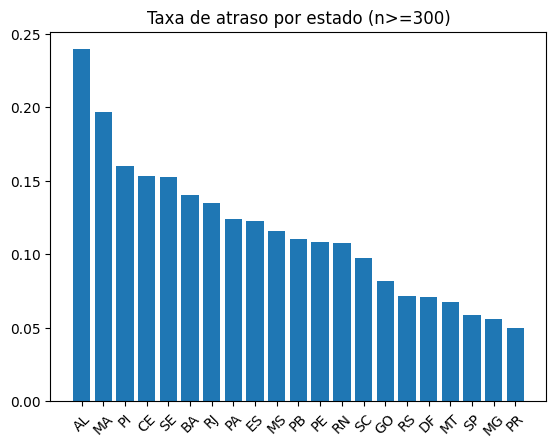

In [188]:
import matplotlib.pyplot as plt

rate_by_state = (
    base.groupBy("customer_state")
        .agg(F.count("*").alias("n"), F.avg("late").alias("late_rate"))
        .filter("n >= 300")
        .orderBy(F.desc("late_rate"))
)

pdf = rate_by_state.toPandas()

plt.figure()
plt.bar(pdf["customer_state"], pdf["late_rate"])
plt.title("Taxa de atraso por estado (n>=300)")
plt.xticks(rotation=45)
plt.show()

1 = pedido atrasou

0 = pedido não atrasou

**Exercícios**:
* Tarefa 1: Ampliar com um ou mais campos ( distancia real (geo), vendedor, transportadora, categoria do produto, volume de pedidos no periodo) buscando aumentar o valor AUC

* Tarefa 2, com base na apostila fazer uso do mesmo dataset, porém com o objtivo de prever o payment_type usando arvore de decisão

In [192]:
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2


In [194]:
# Reconstructing the definition of base_ext and related geo dataframes

from pyspark.sql import functions as F
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2

# geo_customers will contain avg lat/lng for each customer zip code
geo_customers = geolocation_df.groupBy("geolocation_zip_code_prefix") \
    .agg(
        F.avg("geolocation_lat").alias("cust_lat"),
        F.avg("geolocation_lng").alias("cust_lng")
    )

# Link customer IDs to their aggregated lat/lng
customers_with_geo = customers.join(
    geo_customers,
    customers.customer_zip_code_prefix == geo_customers.geolocation_zip_code_prefix,
    "left"
).drop(geo_customers.geolocation_zip_code_prefix) # Drop redundant zip code column

# geo_sellers will contain avg lat/lng for each seller zip code
geo_sellers = geolocation_df.groupBy("geolocation_zip_code_prefix") \
    .agg(
        F.avg("geolocation_lat").alias("seller_lat"),
        F.avg("geolocation_lng").alias("seller_lng")
    )

# Link seller IDs to their aggregated lat/lng
# Use 'sellers_df' from kernel state (already available)
sellers_with_geo = sellers_df.join(
    geo_sellers,
    sellers_df.seller_zip_code_prefix == geo_sellers.geolocation_zip_code_prefix,
    "left"
).drop(geo_sellers.geolocation_zip_code_prefix) # Drop redundant zip code column

# Create base_ext by joining required dataframes
# base has (order_id, customer_id, ...)
# items has (order_id, seller_id, product_id)
# customers_with_geo has (customer_id, cust_lat, cust_lng, ...)
# sellers_with_geo has (seller_id, seller_lat, seller_lng, ...)

base_ext = base \
    .join(items.select("order_id","seller_id","product_id"), ["order_id"], "left") \
    .join(sellers_with_geo.select("seller_id","seller_lat","seller_lng"), ["seller_id"], "left") \
    .join(customers_with_geo.select("customer_id","cust_lat","cust_lng"), ["customer_id"], "left")

# Calculate Haversine distance
R = 6371  # raio da terra (radius of Earth in km)

base_ext = base_ext.withColumn(
    "distancia_km",
    F.when(
        (F.col("cust_lat").isNotNull()) & (F.col("cust_lng").isNotNull()) &
        (F.col("seller_lat").isNotNull()) & (F.col("seller_lng").isNotNull()),
        2 * R * F.atan2(
            F.sqrt(
                F.sin((F.radians(F.col("seller_lat")) - F.radians(F.col("cust_lat")))/2)**2 +
                F.cos(F.radians(F.col("cust_lat"))) * F.cos(F.radians(F.col("seller_lat"))) *
                F.sin((F.radians(F.col("seller_lng")) - F.radians(F.col("cust_lng")))/2)**2
            ),
            F.sqrt(1 - (
                F.sin((F.radians(F.col("seller_lat")) - F.radians(F.col("cust_lat")))/2)**2 +
                F.cos(F.radians(F.col("cust_lat"))) * F.cos(F.radians(F.col("seller_lat"))) *
                F.sin((F.radians(F.col("seller_lng")) - F.radians(F.col("cust_lng")))/2)**2
            ))
        )
    ).otherwise(None) # Handle cases where coordinates might be null
)

# Original code from the selected cell (casting to double)
# This is mainly for robustness, ensuring columns are double in case of schema inference issues or upstream changes.
base_ext = base_ext \
    .withColumn("cust_lat", col("cust_lat").cast("double")) \
    .withColumn("cust_lng", col("cust_lng").cast("double")) \
    .withColumn("seller_lat", col("seller_lat").cast("double")) \
    .withColumn("seller_lng", col("seller_lng").cast("double"))

In [195]:
base_ext = base_ext.filter(
    col("cust_lat").isNotNull() &
    col("seller_lat").isNotNull()
)


In [196]:
from pyspark.sql.functions import count

volume_cliente = base_ext.groupBy("customer_id") \
    .agg(count("order_id").alias("volume_pedidos_cliente"))

base_ext = base_ext.join(volume_cliente, on="customer_id", how="left")


In [197]:
volume_vendedor = base_ext.groupBy("seller_id") \
    .agg(count("order_id").alias("volume_pedidos_vendedor"))

base_ext = base_ext.join(volume_vendedor, on="seller_id", how="left")


In [199]:
from pyspark.ml.feature import StringIndexer

# Carregar o dataset de produtos do Olist
# 'path' é a variável que contém o caminho para os arquivos do dataset do Kaggle.
products_olist = spark.read.csv(path + "/olist_products_dataset.csv", header=True, inferSchema=True)

# Juntar base_ext com products_olist para adicionar a coluna 'product_category_name'
base_ext = base_ext.join(products_olist.select("product_id", "product_category_name"), ["product_id"], "left")

# Agora, aplicar o StringIndexer na coluna 'product_category_name'
indexer_categoria = StringIndexer(
    inputCol="product_category_name",
    outputCol="categoria_index",
    handleInvalid="keep" # Trata categorias inválidas/nulas atribuindo-lhes um índice especial
)

base_ext = indexer_categoria.fit(base_ext).transform(base_ext)

In [201]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[
        "total_price",
        "total_freight",
        "distancia_km",
        "volume_pedidos_cliente",
        "volume_pedidos_vendedor",
        "categoria_index"
    ],
    outputCol="features"
)

base_ml = assembler.transform(base_ext)

In [203]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = base_ml.randomSplit([0.7, 0.3], seed=42)

lr = LogisticRegression(
    labelCol="late",   # sua variável target
    featuresCol="features"
)

modelo = lr.fit(train)

predicoes = modelo.transform(test)

In [205]:
evaluator = BinaryClassificationEvaluator(
    labelCol="late",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predicoes)
print("Novo AUC:", auc)

Novo AUC: 0.565244006432722


# **TAREFA 2 — Prever payment_type com Árvore de Decisão**

In [207]:
from pyspark.ml.feature import StringIndexer

# Carregar o dataset de pagamentos
payments_df = spark.read.csv(path + "/olist_order_payments_dataset.csv", header=True, inferSchema=True)

# Juntar base_ext com payments_df para adicionar a coluna 'payment_type'
# Assumimos que pode haver múltiplos pagamentos por pedido, então vamos pegar o primeiro tipo de pagamento
base_ext_with_payments = base_ext.join(payments_df.select("order_id", "payment_type").dropDuplicates(["order_id"]), ["order_id"], "left")

indexer_pagamento = StringIndexer(
    inputCol="payment_type",
    outputCol="label",
    handleInvalid="skip" # Ignora linhas com payment_type nulo ou inválido
)

base_pag = indexer_pagamento.fit(base_ext_with_payments).transform(base_ext_with_payments)

In [209]:
assembler_pag = VectorAssembler(
    inputCols=[
        "total_price",
        "total_freight",
        "distancia_km",
        "volume_pedidos_cliente"
    ],
    outputCol="features"
)

base_pag = assembler_pag.transform(base_pag)

In [210]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train2, test2 = base_pag.randomSplit([0.7, 0.3], seed=42)

dt = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=5
)

modelo_dt = dt.fit(train2)

pred_dt = modelo_dt.transform(test2)


In [211]:
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    metricName="accuracy"
)

accuracy = evaluator_acc.evaluate(pred_dt)
print("Accuracy Árvore:", accuracy)


Accuracy Árvore: 0.7548741418764302
